In [1]:
%matplotlib inline

import os
import time
import pickle
from multiprocessing import Pool as ThreadPool

import numpy as np

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

from tqdm import tqdm
from tqdm import tqdm_notebook

from sklearn.metrics import accuracy_score

np.random.seed(42)

# Custom imports
from lattice import Lattice

# Set plot params
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

## ----------------------- CODE FROM PROJECT DESCRIPTION -----------------------


In [2]:
# Calculate critical temperature
Tc = 2 / np.log(1+np.sqrt(2))
print(f"Critical temperature: Tc = {Tc:.4f}")

Critical temperature: Tc = 2.2692


In [3]:
# Use 6 threads to run some lattice evolutions
# With current parameters, this took a minute or two on an i7
# Dump out the lattice configurations/temperatures to a file
# and just load it if the file already exists, since this
# is a CPU intensive cell.

fname = "ising_config_data_big.pkl"

def get_lattices(T, N=10, Nlattices=25, Nthermal=200):
    """
    Generates a set of lattices at a given temperature
    
    Args:
        T (float): temperature of the lattice
        N (int): the lattice size
        Nlattices (int): the number of lattices to generate
        Nthermal (int): the number of steps to simulate thermalization
    """
    lattices = []
    for _ in range(Nlattices):
        lat = Lattice(N=N,T=T)
        for _ in range(Nthermal):
            lat.step()
        lattices.append(lat.lattice)
    return round(T, 4), lattices

if not os.path.exists(fname):
    pool = ThreadPool(6)
    Ts = np.arange(5.0,1.0, 0.1)
    d_data = {}
    for T, lattices in pool.imap_unordered(get_lattices, Ts):
        print(T)
        d_data[T] = lattices

    with open(fname,"wb") as fhout:
        pickle.dump(d_data,fhout)
    print(f">>> Dumped to {fname}")

else:
    d_data = pickle.load(open(fname,"rb"))
    print(">>> Loaded from {}".format(str(fname)))

>>> Loaded from ising_config_data_big.pkl


In [4]:
# make vector of input matrices, vector of temperatures
X_data = []
y_data = []
T_data = []

for T,configs in d_data.items():
    for config in configs:
        # flip spins to double dataset keeping E same
        # this is also needed so ML algorithm doesn't learn
        # to prefer one magnetization sign over another
        # also make truth labels (0 is low T phase, 1 is high T phase)
        # and also mirror lattice horizontally/vertically to get free data
        target = 0
        if T > Tc:
            target = 1
            
        X_data.append(config)
        X_data.append(np.flip(config,0))
        X_data.append(np.flip(config,1))
        X_data.append(-config)
        X_data.append(-np.flip(config,0))
        X_data.append(-np.flip(config,1))
        
        for _ in range(6):
            T_data.append(T)
            y_data.append(target)


X_data = np.array(X_data)
y_data = np.array(y_data)
T_data = np.array(T_data)

# convert spin matrices from -1,1 to 0,1
X_data = 0.5*(X_data+1)

# Thus, our training and test sets will consist of 
# the lattice images and the targets will be 0 or 1.
# If the lattice is at low (T<Tc) or high (T>Tc) temperature
# It's up to the NN / CNN to learn the concept of temperature/magnetization/etc.

In [5]:
# function to split the data
def split_data(X_data, y_data, T_data, Thi=4.7, Tlo=1.3, test_size=0,random_state=42):
    """
    Splits the data into train and test sets according to the settings.
    
    Either using sklearn train_test_split (test_size).  
    Or, alternatively, using T>Thi and T<Tlo data as training data and Tlo < T < Thi as predictions/test.
    """
    if test_size:
        print(f"Using sklearn to split data. Test size: {test_size*100:}%")
        X_train, X_test, y_train, y_test, T_train, T_test = \
          train_test_split(X_data, y_data, T_data, test_size=test_size, random_state=random_state)
    elif (Thi and Tlo):
        print(f"Using T>{Thi} and T<{Tlo} as training data.")
        train_set = np.logical_or(T_data>=Thi,T_data<=Tlo)
        test_set = np.logical_not(train_set)
        X_train = X_data[train_set]
        X_test = X_data[test_set]
        y_train = y_data[train_set]
        y_test = y_data[test_set]
        T_train = T_data[train_set]
        T_test = T_data[test_set]
    else:
        print("No rule to split data.")
        return None
        
    print(f"...Training samples: {X_train.shape[0]}")
    print(f"...Testing samples:  {X_test.shape[0]}")
    return(X_train, X_test, y_train, y_test, T_train, T_test)

## ----------------- END OF CODE FROM PROJECT DESCRIPTION -----------------

## Task 2: NN with 3 neurons in the hidden layer.

### Load the data 

In [6]:
X_train, X_test, y_train, y_test, T_train, T_test = split_data(X_data, y_data, T_data,test_size=0.3)

Using sklearn to split data. Test size: 30.0%
...Training samples: 4200
...Testing samples:  1800


In [7]:
# Only interested in the magnetization data
#m_train = X_train[:,2]
#m_test = X_test[:,2]

# Make the data symmetric - encode +-1 instead 0 and 1. 
m_train = np.where(X_train==0, -1,  X_train)
m_test = np.where(X_test==0, -1,  X_test)

# Expand dimensions to len, 1 ,1
#m_train =  np.expand_dims(m_train, 2)
#m_test =  np.expand_dims(m_test, 2)

# One-hot encode targets
#y_train = keras.utils.to_categorical(y_train, 2)
#y_test = keras.utils.to_categorical(y_test, 2)

#print(m_train)

# Flatten input data
#m_train = m_train.flatten()
#m_test = m_test.flatten()

### Define the DNN

### Train and predict

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
==== Epoch: 0 ====
==== Epoch: 10 ====
==== Epoch: 20 ====
==== Epoch: 30 ====
==== Epoch: 40 ====
==== Epoch: 50 ====
==== Epoch: 60 ====
==== Epoch: 70 ====
==== Epoch: 80 ====
==== Epoch: 90 ====
==== Epoch: 100 ====
==== Epoch: 110 ====
==== Epoch: 120 ====
==== Epoch: 130 ====
==== 

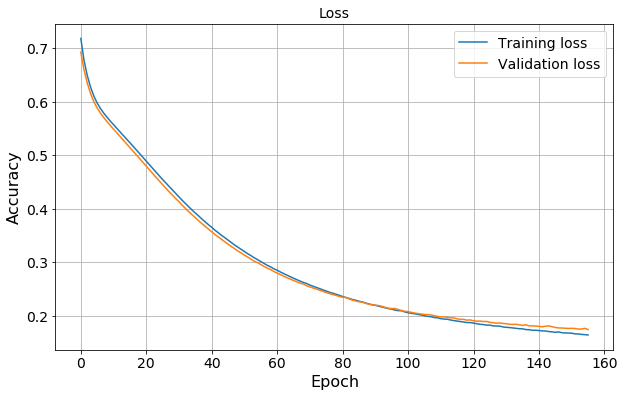

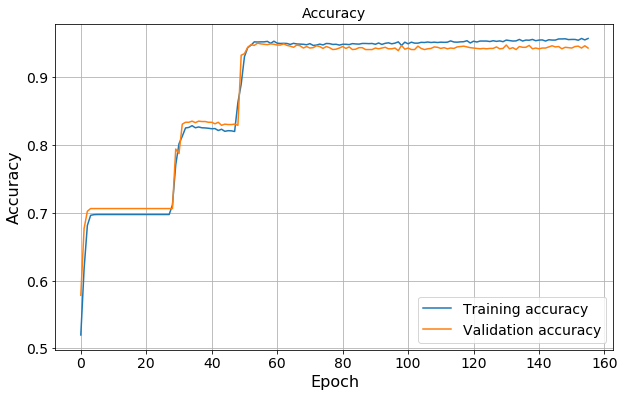

In [8]:
class epochCallback(keras.callbacks.Callback):
    '''Calls back every tenth epoch.'''

    def on_epoch_begin(self, epoch, logs=None):
        if epoch%10==0:
            print(f'==== Epoch: {epoch} ====')

def create_dnn(data, n_neurons=3):
    '''
    Create a DNN using the shape of the data tensor and n_neurons number of neurons in the hidden
    layer, with an L2 regularizer to minimize overfitting. Only take in the magnetization as input data.
    '''
    model = Sequential()
    model.add(Flatten(input_shape=(data.shape[1], data.shape[2])))  # Flatten the 10x10 grid
    hidden_layer = Dense(n_neurons,
                    activation='sigmoid',
                    kernel_regularizer=regularizers.l2(0.01))
    model.add(hidden_layer)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model, hidden_layer

dnn_3, hidden_layer_3 = create_dnn(m_train, 3)
dnn_3.summary()

# Fit on X_train and y_train
hist = dnn_3.fit(x=m_train, 
               y=y_train,
               validation_data=(m_test, y_test),
               epochs=156,
               batch_size=64,
               verbose=0,
                callbacks=[epochCallback()])

# Plot training and test performance
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(hist.history['loss'], label='Training loss')
ax1.plot(hist.history['val_loss'], label='Validation loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Loss")
ax1.grid()
ax1.legend(loc='best')

fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(hist.history['acc'], label='Training accuracy')
ax2.plot(hist.history['val_acc'], label='Validation accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.grid()
ax2.legend(loc='best')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________


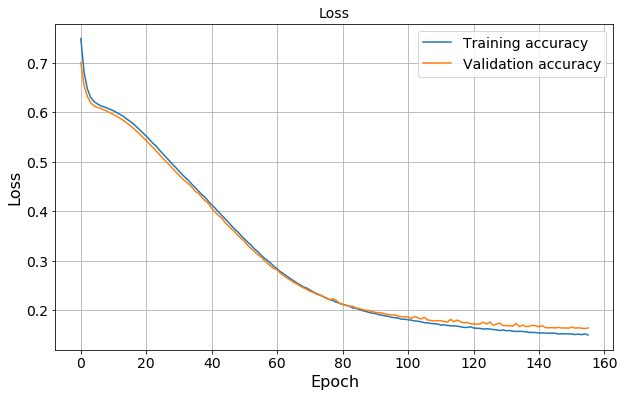

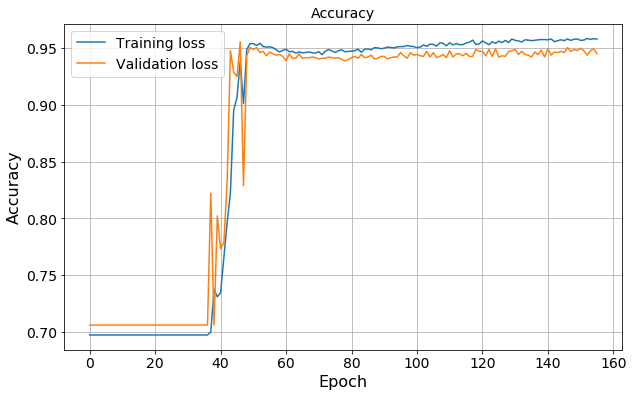

In [9]:
# Do the same for a DNN with ten neurons
dnn_10, hidden_layer_10 = create_dnn(m_train, 10)
dnn_10.summary()

# Fit on X_train and y_train
hist = dnn_10.fit(x=m_train, 
               y=y_train,
               validation_data=(m_test, y_test),
               epochs=156,
               batch_size=64,
               verbose=0)

# Plot training and test performance
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(hist.history['loss'], label='Training accuracy')
ax1.plot(hist.history['val_loss'], label='Validation accuracy')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.grid()
ax1.legend(loc='best')

fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(hist.history['acc'], label='Training loss')
ax2.plot(hist.history['val_acc'], label='Validation loss')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.grid()
ax2.legend(loc='best')

Slope for neuron 0 is a=4.44+-0.0024.
Slope for neuron 1 is a=-6.6+-0.0156.
Slope for neuron 2 is a=-7.22+-0.0149.


Text(0.5, 1.0, 'DNN with 10 neurons')

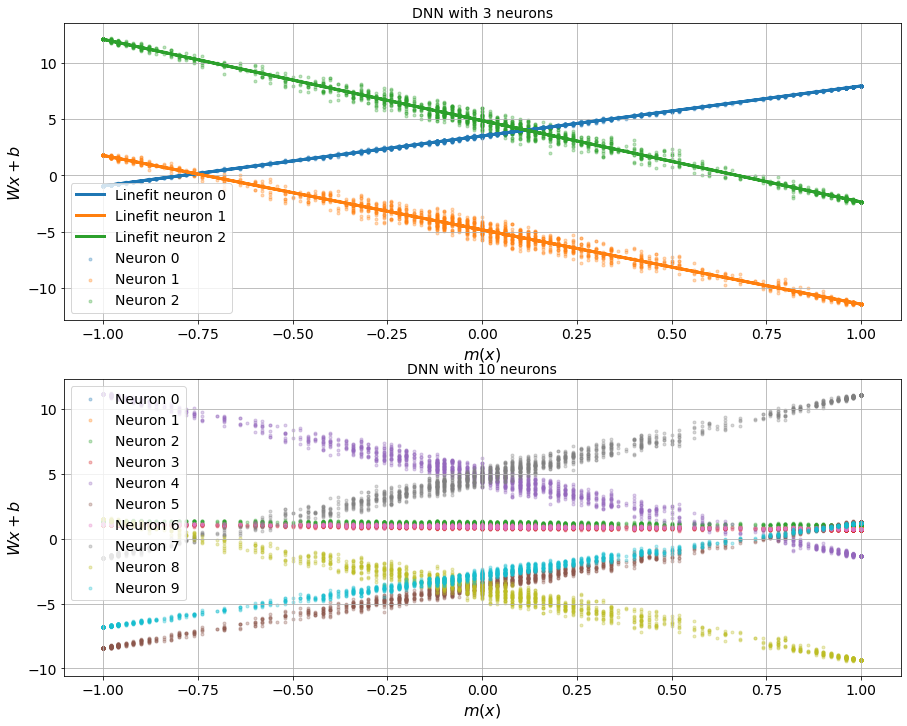

In [10]:
def lin_func(x,a,b):
    '''Linear function for curve fit to output data.'''
    return a*x+b


# Get the weights and plot the intermediate results
W_3 = hidden_layer_3.get_weights()[0]
b_3 = hidden_layer_3.get_weights()[1]

# For 10 neurons
W_10 = hidden_layer_10.get_weights()[0]
b_10 = hidden_layer_10.get_weights()[1]


# The magnetization is the average value of the lattices
mag_vec = m_test.mean(axis=(1,2))

# Rearrange the test data so that it fits our weights - flatten it
m_test_flat = np.array([m_test[i].flatten() for i in range(len(m_test))])

# Calculate intermediate output
inter_out_3 = m_test_flat@W_3 + b_3.T
inter_out_10 = m_test_flat@W_10 + b_10.T

# Plot and do linefits

fig, ax = plt.subplots(2, figsize=(15,12))
for idx in range(inter_out_3.shape[-1]):
    # Do line fits to 3 neuron data
    popt, pcov = curve_fit(lin_func, mag_vec, inter_out_3[:,idx])
    perr = np.sqrt(np.diag(pcov))
    print(f'Slope for neuron {idx} is a={np.round(popt[0],2)}+-{np.round(perr[0], 4)}.')
    ax[0].plot(mag_vec, lin_func(mag_vec, popt[0], popt[1]), linewidth=3, label=f'Linefit neuron {idx}')
    ax[0].scatter(mag_vec, inter_out_3[:,idx], alpha=0.3, marker='.', label=f'Neuron {idx}')
ax[0].grid()
ax[0].set_xlabel(r'$m(x)$')
ax[0].set_ylabel(r'$Wx+b$')
ax[0].legend(loc='best')
ax[0].set_title("DNN with 3 neurons")

for idx in range(inter_out_10.shape[-1]):
    ax[1].scatter(mag_vec, inter_out_10[:,idx], alpha=0.3, marker='.', label=f'Neuron {idx}')
ax[1].grid()
ax[1].set_xlabel(r'$m(x)$')
ax[1].set_ylabel(r'$Wx+b$')
ax[1].legend(loc='best')
ax[1].set_title("DNN with 10 neurons")